In [1]:
# %%
# author: MOHAMED-ABDELLAHI, Mohamed-Abdellahi
# date: 2022-02-12
# description: This class model and price european call/put 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
## i will defintely put each class in a file.. 
## but i guess for now, i will try to make a first viable product 


import numpy as np
from scipy.stats import norm

class Option:
    """
    This class represents a European option and provides methods to calculate its price
    and Greeks using the Black-Scholes model.
    """
    
    def __init__(self, option_type, strike, spot, volatility, risk_free_rate, expiry, dividend=0, position=1):
        """
        Initializes an Option object.
        
        Parameters:
        - option_type (str): "call" or "put" specifying the type of the option.
        - strike (float): Strike price of the option.
        - spot (float): Current price of the underlying asset.
        - volatility (float): Annualized volatility of the underlying asset.
        - risk_free_rate (float): Annualized risk-free interest rate.
        - expiry (float): Time to maturity in years.
        - dividend (float, optional): Dividend yield. Default is 0.
        - position (int, optional): Number of contracts (1 for long, -1 for short). Default is 1.
        """
        self.option_type = option_type
        self.strike = strike
        self.spot = spot
        self.volatility = volatility
        self.risk_free_rate = risk_free_rate
        self.expiry = expiry
        self.dividend = dividend
        self.position = position  

    def _calculate_d1_d2(self, spot, volatility, expiry):
        """
        Computes the d1 and d2 parameters used in the Black-Scholes model.
        """
        d1 = (np.log(spot / self.strike) + (self.risk_free_rate - self.dividend + 0.5 * volatility ** 2) * expiry) / (volatility * np.sqrt(expiry))
        d2 = d1 - volatility * np.sqrt(expiry)
        return d1, d2

    def black_scholes_price(self, spot=None, volatility=None, expiry=None):
        """
        Calculates the theoretical price of the option using the Black-Scholes formula.
        """
        spot = spot if spot is not None else self.spot
        volatility = volatility if volatility is not None else self.volatility
        expiry = expiry if expiry is not None else self.expiry
        d1, d2 = self._calculate_d1_d2(spot, volatility, expiry)
        if self.option_type == 'call':
            price = spot * np.exp(-self.dividend * expiry) * norm.cdf(d1) - self.strike * np.exp(-self.risk_free_rate * expiry) * norm.cdf(d2)
        elif self.option_type == 'put':
            price = self.strike * np.exp(-self.risk_free_rate * expiry) * norm.cdf(-d2) - spot * np.exp(-self.dividend * expiry) * norm.cdf(-d1)
        else:
            raise ValueError("Option type must be 'call' or 'put'")
        return price * self.position

    def delta(self, spot=None, volatility=None, expiry=None):
        """
        Computes the Delta of the option, which measures sensitivity to changes in the underlying price.
        """
        spot = spot if spot is not None else self.spot
        volatility = volatility if volatility is not None else self.volatility
        expiry = expiry if expiry is not None else self.expiry
        d1, _ = self._calculate_d1_d2(spot, volatility, expiry)
        if self.option_type == 'call':
            return np.exp(-self.dividend * expiry) * norm.cdf(d1) * self.position
        elif self.option_type == 'put':
            return np.exp(-self.dividend * expiry) * (norm.cdf(d1) - 1) * self.position

    def gamma(self, spot=None, volatility=None, expiry=None):
        """
        Computes the Gamma of the option, measuring the sensitivity of Delta to changes in the underlying price.
        """
        spot = spot if spot is not None else self.spot
        volatility = volatility if volatility is not None else self.volatility
        expiry = expiry if expiry is not None else self.expiry
        d1, _ = self._calculate_d1_d2(spot, volatility, expiry)
        return np.exp(-self.dividend * expiry) * norm.pdf(d1) / (spot * volatility * np.sqrt(expiry)) * self.position

    def theta(self, spot=None, volatility=None, expiry=None):
        """
        Computes the Theta of the option, which measures sensitivity to time decay.
        """
        spot = spot if spot is not None else self.spot
        volatility = volatility if volatility is not None else self.volatility
        expiry = expiry if expiry is not None else self.expiry
        d1, d2 = self._calculate_d1_d2(spot, volatility, expiry)
        if self.option_type == 'call':
            theta = -(spot * norm.pdf(d1) * volatility / (2 * np.sqrt(expiry))) - self.risk_free_rate * self.strike * np.exp(-self.risk_free_rate * expiry) * norm.cdf(d2) + self.dividend * spot * np.exp(-self.dividend * expiry) * norm.cdf(d1)
        elif self.option_type == 'put':
            theta = -(spot * norm.pdf(d1) * volatility / (2 * np.sqrt(expiry))) + self.risk_free_rate * self.strike * np.exp(-self.risk_free_rate * expiry) * norm.cdf(-d2) - self.dividend * spot * np.exp(-self.dividend * expiry) * norm.cdf(-d1)
        return theta * self.position
    
    


    def vanna(self, spot=None, volatility=None, expiry=None):
        spot = spot if spot is not None else self.spot
        volatility = volatility if volatility is not None else self.volatility
        expiry = expiry if expiry is not None else self.expiry
        d1, d2 = self._calculate_d1_d2(spot, volatility, expiry)
        return -np.exp(-self.dividend * expiry) * norm.pdf(d1) * d2 / volatility * self.position

    def volga(self, spot=None, volatility=None, expiry=None):
        spot = spot if spot is not None else self.spot
        volatility = volatility if volatility is not None else self.volatility
        expiry = expiry if expiry is not None else self.expiry
        d1, d2 = self._calculate_d1_d2(spot, volatility, expiry)
        return spot * np.exp(-self.dividend * expiry) * norm.pdf(d1) * np.sqrt(expiry) * d1 * d2 / volatility * self.position


    def compute_pnl(self, spot_shift, time_shift):
        """
        Computes the P&L of a delta-hedged option based on changes in the underlying price and time decay.
        
        Parameters:
        - spot_shift (float): Change in underlying price.
        - time_shift (float): Change in time (in years).
        
        Returns:
        - P&L based on Gamma and Theta effects.
        """
        gamma_pnl = 0.5 * self.gamma() * (spot_shift ** 2)
        theta_pnl = self.theta() * time_shift
        return gamma_pnl + theta_pnl

In [5]:
# author: MOHAMED-ABDELLAHI, Mohamed-Abdellahi
# date: 2022-02-12
# description: The main idea is to model a trading book of derivative

import numpy as np
import pandas as pd
from option import Option  

class BookEurostoxx50:
    def __init__(self):
        self.options = []
        self.stock_position = 0  # Position sur le sous-jacent 
        self.stock_simulation_data = None  # Données de simulation du stock
        self.book = {}  # Dictionnaire pour stocker les résultats de simulation pour chaque option

    def add_option(self, option):
        self.options.append(option)

    def add_stock_position(self, quantity):
        self.stock_position += quantity

    def simulate_stock_brownian(self, spot_price, volatility, risk_free_rate, dividend, num_steps, total_time, seed):
       
        """
        Simulates stock price using Geometric Brownian Motion.

        Parameters:
        - spot_price (float): Initial stock price.
        - volatility (float): Annualized volatility.
        - risk_free_rate (float): Risk-free interest rate.
        - dividend (float): Dividend yield.
        - num_steps (int): Number of simulation steps.
        - total_time (float): Total simulation time (in years).
        - seed (int, optional): Random seed for reproducibility.

        Returns:
        - DataFrame with simulated stock prices over time.
        """
        if seed is not None:
            np.random.seed(seed)  # Set the random seed

        dt = total_time / num_steps
        prices = [spot_price]
        times = [0]
        

        for t in range(1, num_steps):
            dW = np.random.normal(0, np.sqrt(dt))
            next_price = prices[-1] * np.exp((risk_free_rate - dividend - 0.5 * volatility ** 2) * dt + volatility * dW)
            prices.append(next_price)
            times.append(times[-1] + dt)

        # Création de la table de simulation du stock
        stock_simulation_df = pd.DataFrame({
            'Date': times,
            'Stock Price': prices,
            'Volatility': volatility,
            'Rate': risk_free_rate,
            'Dividend': dividend
        })

        self.stock_simulation_data = stock_simulation_df
        return stock_simulation_df


    def simulate_spot(self, spot_price, volatility, risk_free_rate, dividend, num_steps, total_time):
        prices = np.arange(0, 201, 1)  # Prix de 0 à 200
        times = np.zeros_like(prices)  # Temps fixe
        
        stock_simulation_df = pd.DataFrame({
            'Date': times,
            'Stock Price': prices,
            'Volatility': volatility,
            'Rate': risk_free_rate,
            'Dividend': dividend
        })
        
        self.stock_simulation_data = stock_simulation_df
        return stock_simulation_df

    def simulate_option(self, option, stock_simulation_df):
        option_simulation_data = []

        for index, row in stock_simulation_df.iterrows():
            time_to_maturity = option.expiry - row['Date']
            if time_to_maturity > 0:
                option_data = {
                    'Date': row['Date'],
                    'Time to Maturity': time_to_maturity,
                    'Stock Price': row['Stock Price'],
                    'Volatility': row['Volatility'],
                    'Rate': row['Rate'],
                    'Delta': option.delta(spot=row['Stock Price'], volatility=row['Volatility'], expiry=time_to_maturity),
                    'Gamma': option.gamma(spot=row['Stock Price'], volatility=row['Volatility'], expiry=time_to_maturity),
                    'Vega': option.vega(spot=row['Stock Price'], volatility=row['Volatility'], expiry=time_to_maturity),
                    'Theta': option.theta(spot=row['Stock Price'], volatility=row['Volatility'], expiry=time_to_maturity),
                    'Rho': option.rho(spot=row['Stock Price'], volatility=row['Volatility'], expiry=time_to_maturity),
                    'Volga': option.volga(spot=row['Stock Price'], volatility=row['Volatility'], expiry=time_to_maturity),
                    'Vanna': option.vanna(spot=row['Stock Price'], volatility=row['Volatility'], expiry=time_to_maturity),
                    'Theoretical Price': option.black_scholes_price(spot=row['Stock Price'], volatility=row['Volatility'], expiry=time_to_maturity)
                }
                option_simulation_data.append(option_data)

        option_simulation_df = pd.DataFrame(option_simulation_data)
        self.book[option] = option_simulation_df
        return option_simulation_df

    def aggregate_portfolio_results(self):
        if not self.book:
            return pd.DataFrame()

        first_option = next(iter(self.book))
        aggregated_df = self.book[first_option].copy()
        aggregated_df.iloc[:, 4:] = 0

        for option, df in self.book.items():
            for col in df.columns[4:]:
                aggregated_df[col] += df[col]

        self.book['Aggregated'] = aggregated_df
        return aggregated_df


In [6]:
def plot_all_greeks(df, axis):
    columns_to_plot = ['Stock Price','Delta', 'Gamma', 'Vega', 'Theta', 'Rho', 'Volga', 'Vanna', 'Theoretical Price']
    num_plots = len(columns_to_plot)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(16, 8))  
    axes = axes.flatten()

    for i, col in enumerate(columns_to_plot):
        axes[i].plot(df[axis], df[col], label=col, color="blue")
        axes[i].set_xlabel(axis)
        axes[i].set_ylabel(col)
        axes[i].set_title(f"Evolution of the {col}")
        axes[i].legend()
        axes[i].grid()

        # Ajuster dynamiquement les limites de l'axe X
        axes[i].set_xlim([df[axis].min(), df[axis].max()])
        
        # Ajuster les ticks de l'axe X pour plus de lisibilité
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

/Users/mohamedabdellahi/Desktop/Trust the process/0.projects/derivatives/option.py:25: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(spot / self.strike) + (self.risk_free_rate - self.dividend + 0.5 * volatility ** 2) * expiry) / (volatility * np.sqrt(expiry))
/Users/mohamedabdellahi/Desktop/Trust the process/0.projects/derivatives/option.py:57: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(-self.dividend * expiry) * norm.pdf(d1) / (spot * volatility * np.sqrt(expiry)) * self.position
/Users/mohamedabdellahi/Desktop/Trust the process/0.projects/derivatives/option.py:99: RuntimeWarning: invalid value encountered in scalar multiply
  return spot * np.exp(-self.dividend * expiry) * norm.pdf(d1) * np.sqrt(expiry) * d1 * d2 / volatility * self.position
/Users/mohamedabdellahi/Desktop/Trust the process/0.projects/derivatives/option.py:92: RuntimeWarning: invalid value encountered in scalar multiply
  return -np.exp(-self.dividend * expiry) * nor

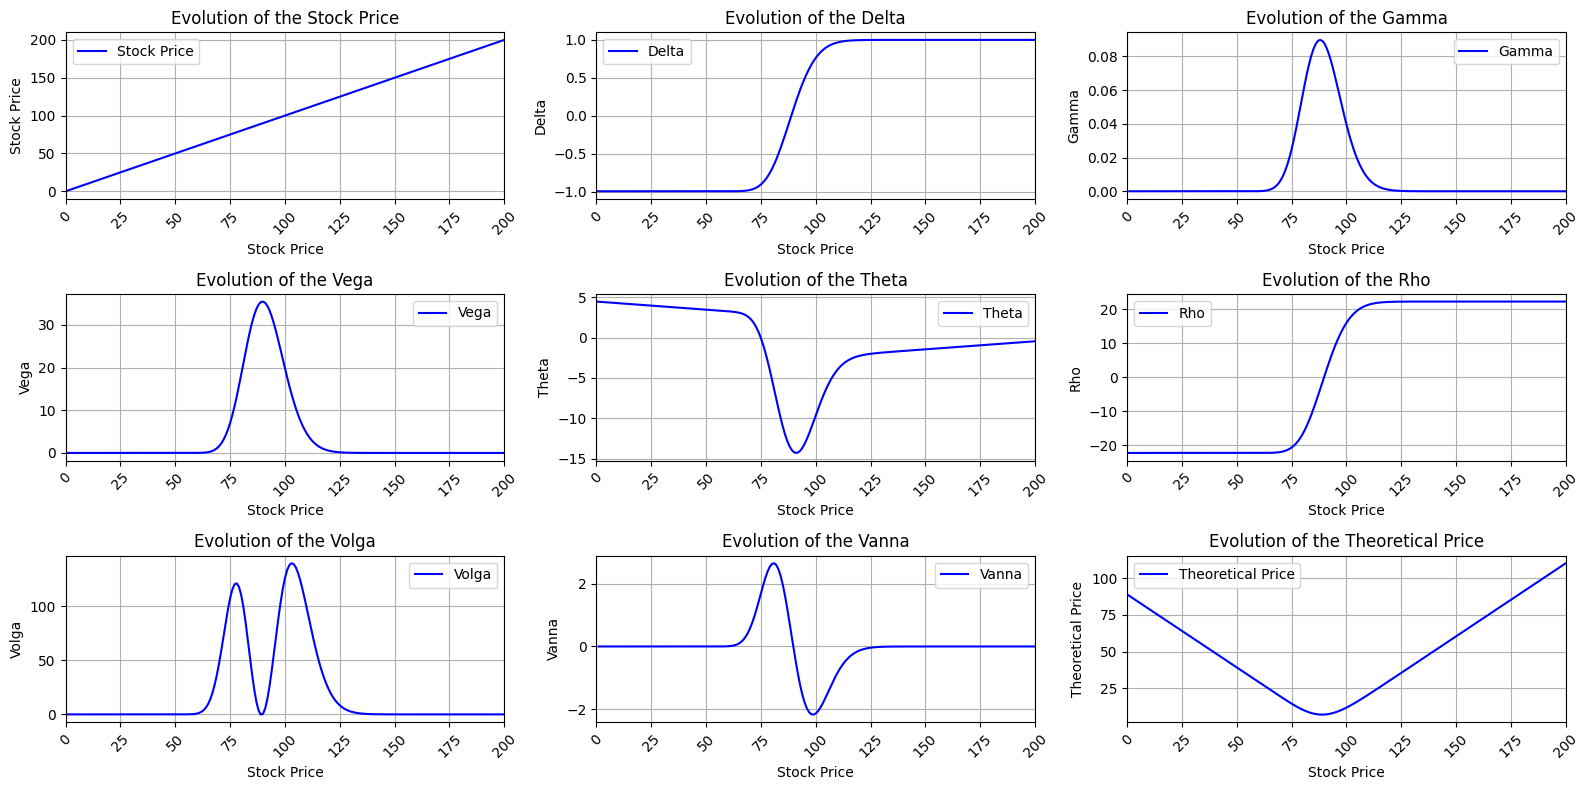

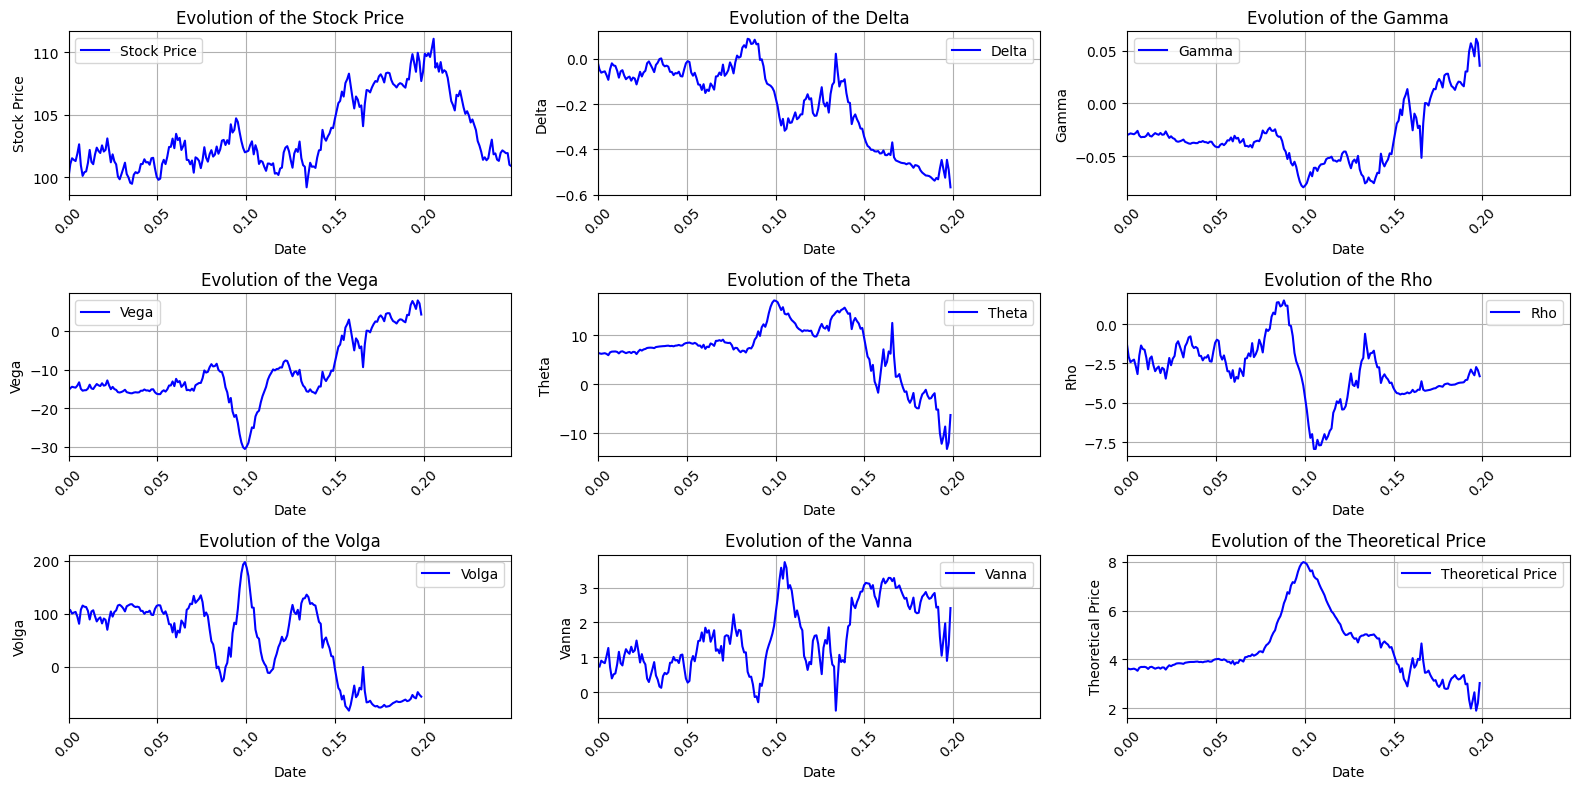

In [19]:
####################@ THE MAIN 
# first example is a straddle strategy
# this is a strategy that is long a call and a put with the same strike price

# 1-  set up ur param
option_type_call = "call"
option_type_put = "put"
strike_call = 90
strike_put = 90  
expiry = 0.25  # 3 mois

dividend = 0.02
spot_price = 100
volatility = 0.2
risk_free_rate = 0.05

# 2-  create your options
# Straddle Strategy
call_option = Option(option_type=option_type_call, strike=strike_call, spot=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, expiry=expiry, dividend=dividend, position=1)
put_option = Option(option_type=option_type_put, strike=strike_put, spot=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, expiry=expiry, dividend=dividend, position= 1)

# add ur options in the book
book = BookEurostoxx50()
book.add_option(call_option)
book.add_option(put_option)

# the below simulation, it's mean goal is to plot the payoff and greeks profile vs the spot 
monotonneIncreasingStock= book.simulate_spot(spot_price=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, dividend=dividend, num_steps=252, total_time=0.25)

call_simulation_df = book.simulate_option(call_option, monotonneIncreasingStock)
put_simulation_df = book.simulate_option(put_option, monotonneIncreasingStock)

payoffVsSpot_df = book.aggregate_portfolio_results()
plot_all_greeks(payoffVsSpot_df, "Stock Price")


# this simulation is using Geometric Brownian Motion
stock_simulation_df = book.simulate_stock_brownian(spot_price=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, dividend=dividend, num_steps=252, total_time=0.25, seed= 2024)
call_simulation_df = book.simulate_option(call_option, stock_simulation_df)
put_simulation_df = book.simulate_option(put_option, stock_simulation_df)
strategy_df = book.aggregate_portfolio_results()
plot_all_greeks(aggregated_df, "Date")
# %%

/Users/mohamedabdellahi/Desktop/Trust the process/0.projects/derivatives/option.py:25: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(spot / self.strike) + (self.risk_free_rate - self.dividend + 0.5 * volatility ** 2) * expiry) / (volatility * np.sqrt(expiry))
/Users/mohamedabdellahi/Desktop/Trust the process/0.projects/derivatives/option.py:57: RuntimeWarning: invalid value encountered in scalar divide
  return np.exp(-self.dividend * expiry) * norm.pdf(d1) / (spot * volatility * np.sqrt(expiry)) * self.position
/Users/mohamedabdellahi/Desktop/Trust the process/0.projects/derivatives/option.py:99: RuntimeWarning: invalid value encountered in scalar multiply
  return spot * np.exp(-self.dividend * expiry) * norm.pdf(d1) * np.sqrt(expiry) * d1 * d2 / volatility * self.position
/Users/mohamedabdellahi/Desktop/Trust the process/0.projects/derivatives/option.py:92: RuntimeWarning: invalid value encountered in scalar multiply
  return -np.exp(-self.dividend * expiry) * nor

payoff profile and greeks


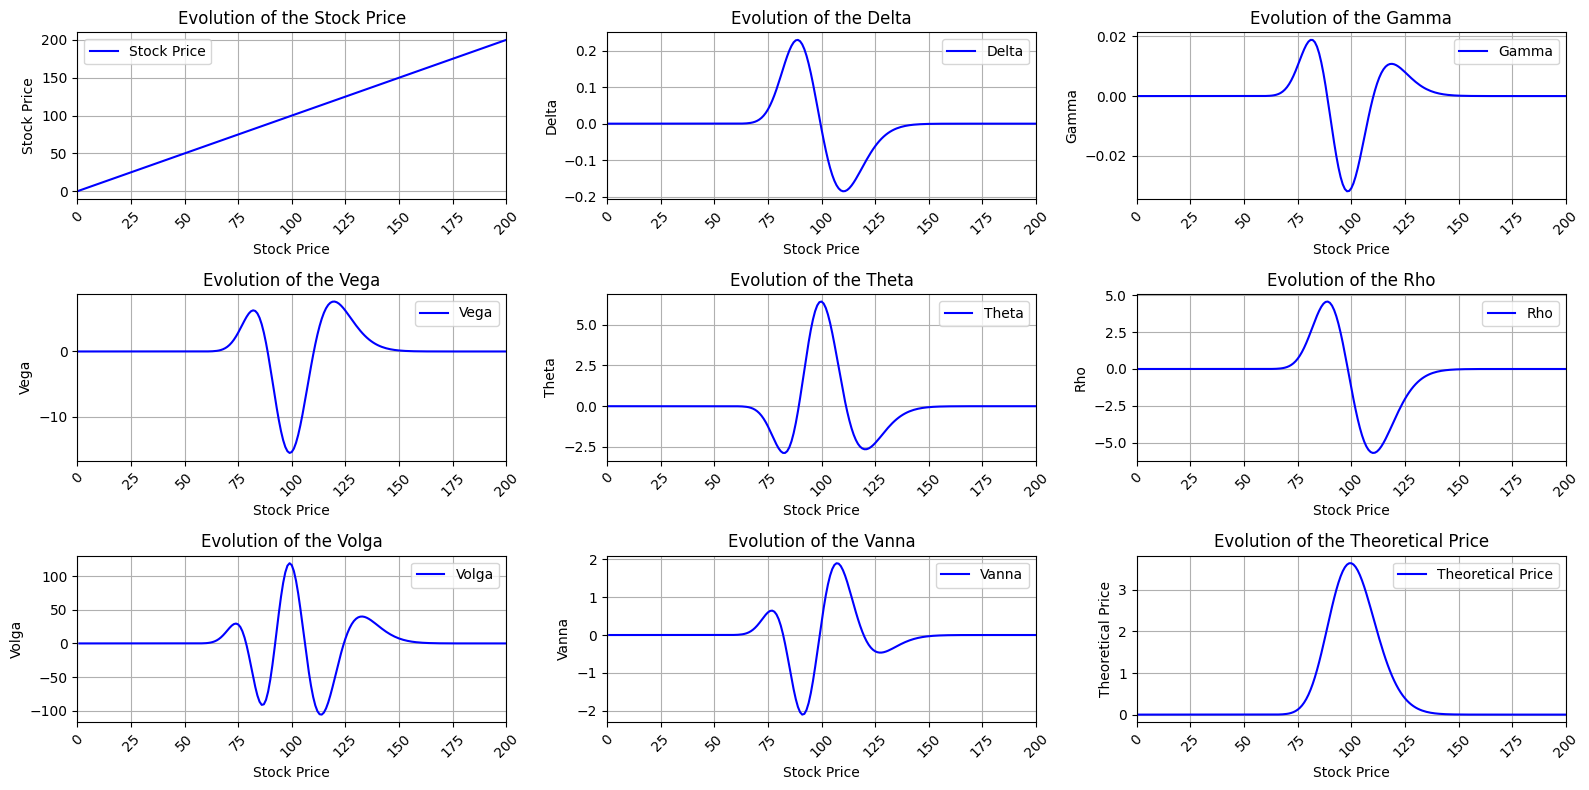

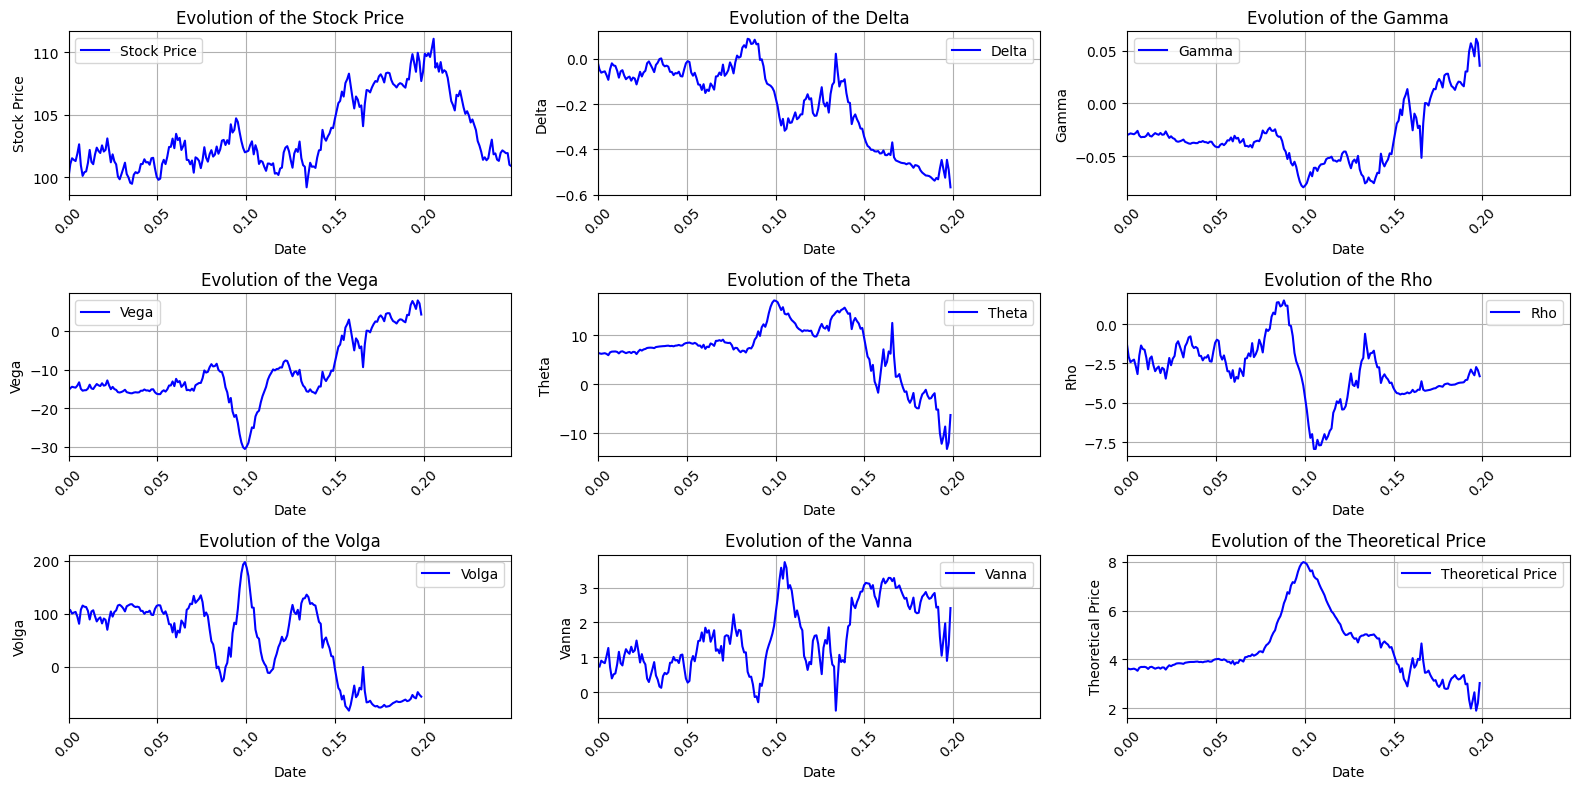

In [17]:
# Butterfly Spread Strategy

#set up ur parameters

option_type = "call"
strike_low = 90
strike_mid = 100
strike_high = 110
expiry = 0.25  # 3 mois
dividend = 0.02
spot_price = 100
volatility = 0.2
risk_free_rate = 0.05

# create ur options
low_call = Option(option_type=option_type, strike=strike_low, spot=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, expiry=expiry, dividend=dividend, position=1)
mid_call = Option(option_type=option_type, strike=strike_mid, spot=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, expiry=expiry, dividend=dividend, position=-2)
high_call = Option(option_type=option_type, strike=strike_high, spot=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, expiry=expiry, dividend=dividend, position=1)

# add them in the book
book2 = BookEurostoxx50()
book2.add_option(low_call)
book2.add_option(mid_call)
book2.add_option(high_call)

                ## pour voir le profil du payoff:
## simuler un prix allant de 0 à 200% pour voir le payoff 
monotonneIncreasingStock= book2.simulate_spot(spot_price=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, dividend=dividend, num_steps=252, total_time=0.25)
low_call_simulation_df = book2.simulate_option(low_call, monotonneIncreasingStock)
mid_call_simulation_df = book2.simulate_option(mid_call, monotonneIncreasingStock)
high_call_simulation_df = book2.simulate_option(high_call, monotonneIncreasingStock)
aggregated_df = book2.aggregate_portfolio_results()

print("payoff profile and greeks")
plot_all_greeks(aggregated_df, "Stock Price") 


# Simulation du stock
stock_simulation_df = book2.simulate_stock_brownian(spot_price=spot_price, volatility=volatility, risk_free_rate=risk_free_rate, dividend=dividend, num_steps=252, total_time=0.25, seed= 2024)


# Simulation des options
low_call_simulation_df = book2.simulate_option(low_call, stock_simulation_df)
mid_call_simulation_df = book2.simulate_option(mid_call, stock_simulation_df)
high_call_simulation_df = book2.simulate_option(high_call, stock_simulation_df)


aggregated_df = book2.aggregate_portfolio_results()


plot_all_greeks(aggregated_df, "Date")